# Introduction

Diabetes mellitus is a chronic health condition where blood glucose level of the body reaches very high. The impact of diabetes is very serious if not taken good care. In recent studies, it showed patients of COVID-19 with diabetes grow a severe clinical course and also have increased chance of mortality. Hence, for any health provider it is important to know the COVID-19 patient's chronic health conditions like diabetes so that COVID-19 patient with diabetes required extra care.<br>
<br>
Hence, in this notebook, an attempt is made to predict whether COVID-19 patient admitted to ICU is living with diabetes. This study primarily uses ICU parameters such as h1_mbp_max, h1_mbp_min, d1_calcium_min etc to predict the diabetes in the patients using supervised machine learning techniques. Various machine learning models are implemented for the given dataset for the diabetes prediction and finally best suited model is suggested based on its performance. Additionally, dimensionality reduction techniques such as feature selection and feature extraction are also implemented and many other machine learning techniques for handling class imbalanced and dealing with missing values are discussed. 

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from category_encoders import OrdinalEncoder
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsRegressor
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf 
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import itertools
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.decomposition import PCA
import sklearn.metrics as metrics

# Retrive Dataset

In [2]:
df = pd.read_csv("Dataset.csv",index_col=0)

#  Checking class imbalanced dataset

<AxesSubplot:xlabel='diabetes_mellitus'>

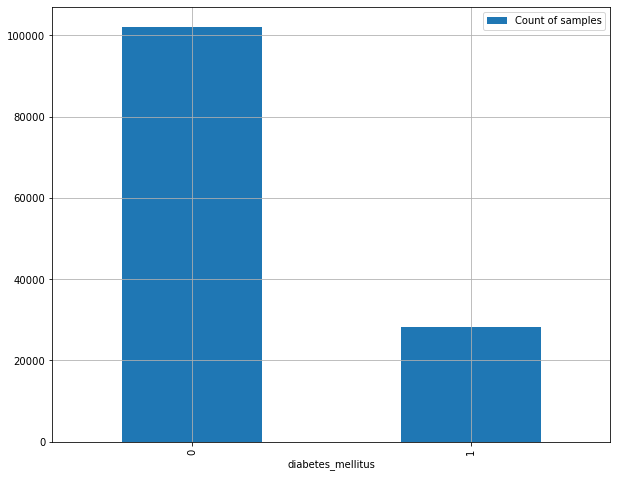

In [3]:
df_target=pd.DataFrame(df['diabetes_mellitus'].value_counts(),  columns=['diabetes_mellitus'])
df_target.rename(columns={'diabetes_mellitus': 'Count of samples'},inplace=True)
df_target['diabetes_mellitus'] = df_target.index
df_target.plot.bar(x='diabetes_mellitus',y='Count of samples',figsize=(10,8), grid=True)

Above plot shows it is a class imbalanced data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130157 entries, 1 to 130157
Columns: 180 entries, encounter_id to diabetes_mellitus
dtypes: float64(157), int64(17), object(6)
memory usage: 179.7+ MB


# Encode the categorical variables

Encoding the categorical variables using OrdinalEncoder

In [5]:
train_cols=[]
for i in df.columns:
    if df[i].dtypes=='object':
        train_cols.append(i)
        
print(train_cols)

['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type']


In [6]:
def encoding_data(col):
    oe = OrdinalEncoder()
    oe.fit(df[col])
    train_cat = oe.transform(df[col])
    
    if col=='gender':
        train_cat[col]= np.where(train_cat[col]==3, np.nan  ,train_cat[col])
    elif col== 'ethnicity':
        train_cat[col]= np.where(train_cat[col]==2, np.nan  ,train_cat[col])
    elif col == 'icu_admit_source':
        train_cat[col]= np.where(train_cat[col]==6, np.nan  ,train_cat[col])
    elif col == 'hospital_admit_source':
        train_cat[col]= np.where(train_cat[col]==4, np.nan  ,train_cat[col])
    else:
        train_cat[col]= train_cat[col]
    
    return train_cat

In [7]:
df['icu_type'] = encoding_data('icu_type')
df['ethnicity'] = encoding_data('ethnicity')
df['gender'] = encoding_data('gender')
df['hospital_admit_source'] = encoding_data('hospital_admit_source')
df['icu_admit_source'] = encoding_data('icu_admit_source')
df['icu_stay_type'] = encoding_data('icu_stay_type')

# Finding missing value

Function to determine missing value in the dataset

In [8]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

# Deleting features having more than 90% missing value

In [9]:
nan_cols = []
for col in df.columns:
     nan_ratio = df[col].isnull().sum() / df.shape[0]
     if nan_ratio >= 0.90:
         nan_cols.append(col)
df = df.drop(nan_cols, axis=1)

In [10]:
cols=missing_values_table(df)

Your selected dataframe has 174 columns.
There are 154 columns that have missing values.


In [11]:
df.fillna(-999,inplace=True)

# Applying under sampling

When dealing with imbalanced data, came across many technique. For this particular dataset, under sampling is best suitable because we have huge number of samples. So, reducing dataset using under sampling would not effect.

In [12]:
nm = NearMiss()
X_UnderSamp , y_UnderSamp = nm.fit_resample(df.drop('diabetes_mellitus',axis=1), df['diabetes_mellitus'])

In [13]:
X_UnderSamp.shape, y_UnderSamp.shape

((56302, 173), (56302,))

In [14]:
X=X_UnderSamp.replace(-999, np.nan)
y= y_UnderSamp

<AxesSubplot:>

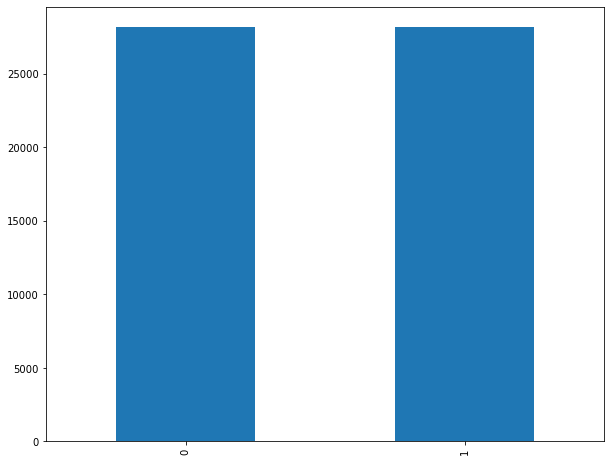

In [15]:
y.value_counts().plot.bar(figsize=(10,8))

After undersampling, dataset sample reduced to 56302.

# Impute missing value for catogorical features

In [16]:
class_cat_feats=['ethnicity',
 'gender',
 'hospital_admit_source',
 'icu_admit_source',
 'icu_stay_type',
 'icu_type',
'readmission_status',
'apache_2_diagnosis',
'apache_3j_diagnosis',
'arf_apache',
'gcs_unable_apache',
'intubated_apache',
'ventilated_apache',
 'elective_surgery',
 'apache_post_operative',
 'aids',
 'cirrhosis',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [17]:
cat_col = [col for col in class_cat_feats if col not in nan_cols]
con_col = [col for col in X.columns if col not in class_cat_feats]

In [18]:
imp_1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X[cat_col]=imp_1.fit_transform(X[cat_col])

# Impute missing value for continuous features

In [19]:
lr=KNeighborsRegressor(n_neighbors=50)
imp=IterativeImputer(estimator= lr,
                     verbose=2,max_iter=3,tol=1e-10, imputation_order='roman')
df_con=pd.DataFrame(imp.fit_transform(X))

[IterativeImputer] Completing matrix with shape (56302, 173)
[IterativeImputer] Ending imputation round 1/3, elapsed time 854.37
[IterativeImputer] Change: 1133.634659399114, scaled tolerance: 2.78999e-05 
[IterativeImputer] Ending imputation round 2/3, elapsed time 1696.51
[IterativeImputer] Change: 674.2318452799997, scaled tolerance: 2.78999e-05 
[IterativeImputer] Ending imputation round 3/3, elapsed time 2549.72
[IterativeImputer] Change: 539.5840406399998, scaled tolerance: 2.78999e-05 


C:\Users\aditi\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [20]:
df_con.columns=X.columns
X=df_con

# Data transform

In [21]:
scaler= StandardScaler()
X=pd.DataFrame(scaler.fit_transform(X))
X.columns=df_con.columns

# Splitting the data into train and test data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test.value_counts(), y_train.value_counts()

(1    8453
 0    8438
 Name: diabetes_mellitus, dtype: int64,
 0    19713
 1    19698
 Name: diabetes_mellitus, dtype: int64)

# Artifitial neural network

In [23]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [24]:

history = model.fit(x=X_train ,y=y_train,validation_split=0.2,batch_size=32, epochs=25, 
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, patience=1)])

Epoch 1/25
986/986 [==============================] - 6s 4ms/step - loss: 0.4564 - accuracy: 0.7896 - val_loss: 0.4518 - val_accuracy: 0.7954
Epoch 2/25
986/986 [==============================] - 4s 4ms/step - loss: 0.4062 - accuracy: 0.8165 - val_loss: 0.4277 - val_accuracy: 0.8044
Epoch 3/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3839 - accuracy: 0.8274 - val_loss: 0.4257 - val_accuracy: 0.8088
Epoch 4/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3652 - accuracy: 0.8378 - val_loss: 0.4409 - val_accuracy: 0.8078
Epoch 5/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3085 - accuracy: 0.8624 - val_loss: 0.4525 - val_accuracy: 0.8121
Epoch 6/25
986/986 [==============================] - 4s 4ms/step - loss: 0.2823 - accuracy: 0.8744 - val_loss: 0.4537 - val_accuracy: 0.8111
Epoch 7/25
986/986 [==============================] - 5s 5ms/step - loss: 0.2792 - accuracy: 0.8756 - val_loss: 0.4543 - val_accuracy: 0.8111
Epoch 

In [25]:
model.evaluate(X_test,y_test)

528/528 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.8187


[0.42722445726394653, 0.8186607956886292]

In [26]:
#Function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('RdBu')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.6f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "white")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center", fontsize = 'xx-large',
                     color="white" if cm[i, j] > thresh else "white")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

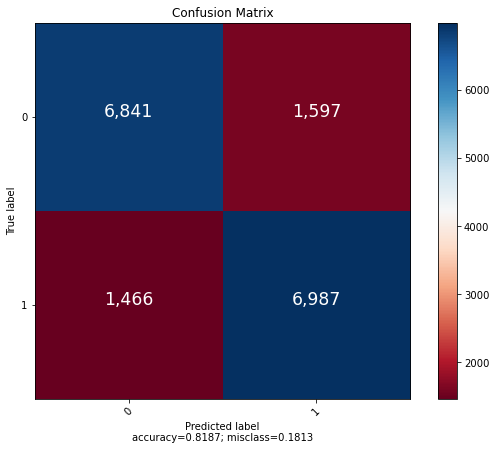

In [27]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
cm= confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [28]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      8438
           1       0.81      0.83      0.82      8453

    accuracy                           0.82     16891
   macro avg       0.82      0.82      0.82     16891
weighted avg       0.82      0.82      0.82     16891



In [29]:
def draw_roc(X, y, model):
    probs = model.predict_proba(X)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

C:\Users\aditi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


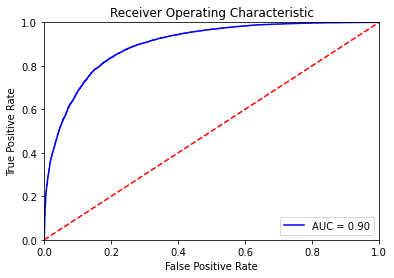

In [30]:
draw_roc(X_test, y_test, model)

# XGBoost

In [31]:
xgb1 = XGBClassifier( 
 learning_rate =0.1,
 n_estimators=1200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)
xgb1.fit(X_train, y_train)

[09:30:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [32]:
pred = xgb1.predict(X_test)
print(accuracy_score(y_test, pred))

0.8456574507133977


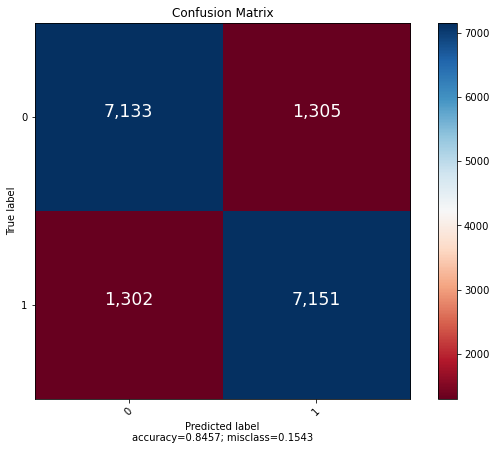

In [33]:
XGB_cm2=confusion_matrix(y_test, pred)
plot_confusion_matrix(XGB_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      8438
           1       0.85      0.85      0.85      8453

    accuracy                           0.85     16891
   macro avg       0.85      0.85      0.85     16891
weighted avg       0.85      0.85      0.85     16891



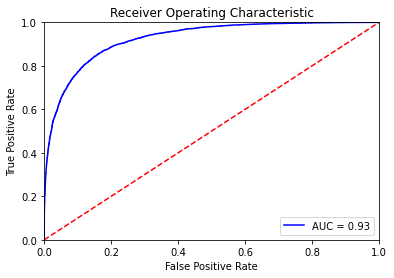

In [35]:
draw_roc(X_test, y_test, xgb1)

# CatBoost

In [36]:
model_cat = CatBoostClassifier(verbose=False,iterations=50)
model_cat.fit(X_train, y_train)

In [37]:
predictions = model_cat.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8347048724172637


In [38]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      8438
           1       0.84      0.83      0.83      8453

    accuracy                           0.83     16891
   macro avg       0.83      0.83      0.83     16891
weighted avg       0.83      0.83      0.83     16891



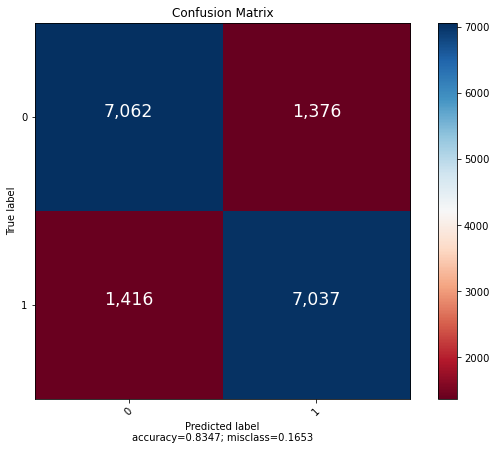

In [39]:
cm=confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

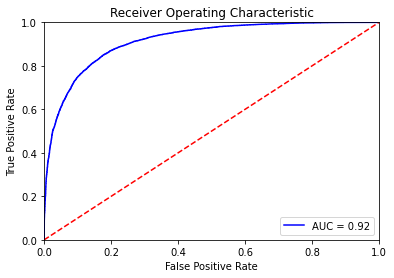

In [40]:
draw_roc(X_test, y_test, model_cat)

# Random Forest

In [41]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=40, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)
y_pred_rand=random_forest.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [42]:
print("Accuracy:",accuracy_score(y_test, y_pred_rand))

Accuracy: 0.8200817003137766


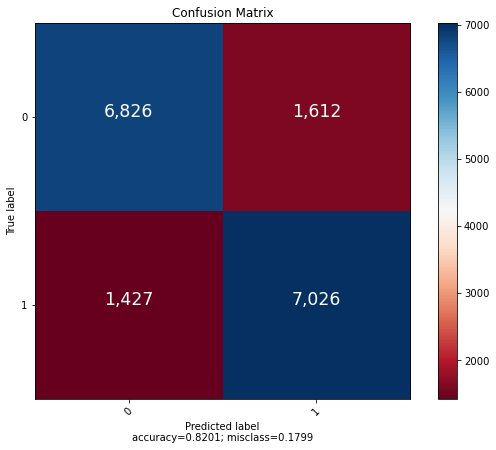

In [43]:
rand_cm2=confusion_matrix(y_test, y_pred_rand)
plot_confusion_matrix(rand_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [44]:
print(classification_report(y_test, y_pred_rand))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      8438
           1       0.81      0.83      0.82      8453

    accuracy                           0.82     16891
   macro avg       0.82      0.82      0.82     16891
weighted avg       0.82      0.82      0.82     16891



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


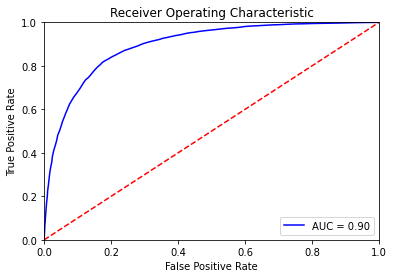

In [45]:
draw_roc(X_test, y_test, random_forest)

# Decision Tree

In [46]:
Decision_model=DecisionTreeClassifier()
Decision_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [47]:
y_pred_Decission=Decision_model.predict(X_test)

In [48]:
print("Accuracy:",accuracy_score(y_test, y_pred_Decission))

Accuracy: 0.7242910425670476


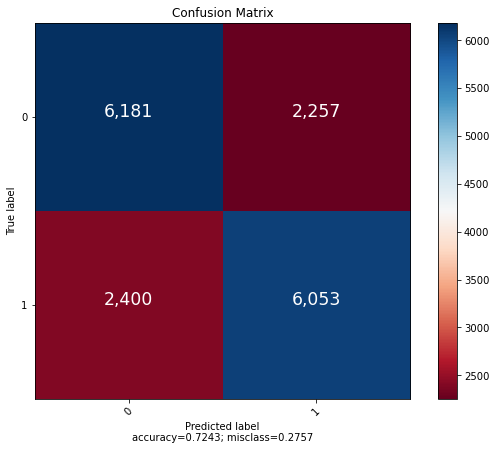

In [49]:
DT=confusion_matrix(y_test, y_pred_Decission)
plot_confusion_matrix(DT, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [50]:
print(classification_report(y_test, y_pred_Decission))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73      8438
           1       0.73      0.72      0.72      8453

    accuracy                           0.72     16891
   macro avg       0.72      0.72      0.72     16891
weighted avg       0.72      0.72      0.72     16891



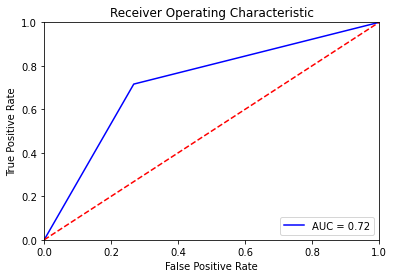

In [51]:
draw_roc(X_test, y_test, Decision_model)

# Feature selection

Applying mutual information feature selection to reduce the dimensionality of the dataset

In [52]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info= pd.Series(mutual_info)

Displaying 20 most important features to predict diabetes

<AxesSubplot:>

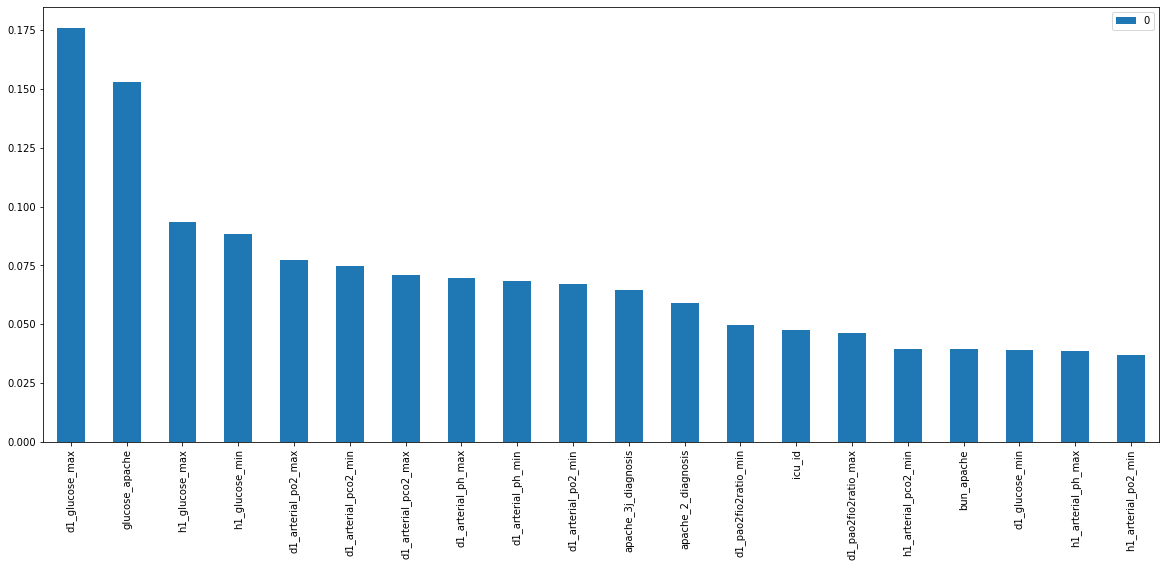

In [53]:
mutual_info.index = df.drop('diabetes_mellitus', axis=1).columns
p=pd.DataFrame(mutual_info.sort_values(ascending=False)[:20])
p.plot.bar(figsize=(20,8))

Displaying all features based on their mutual info value in descending order

<AxesSubplot:>

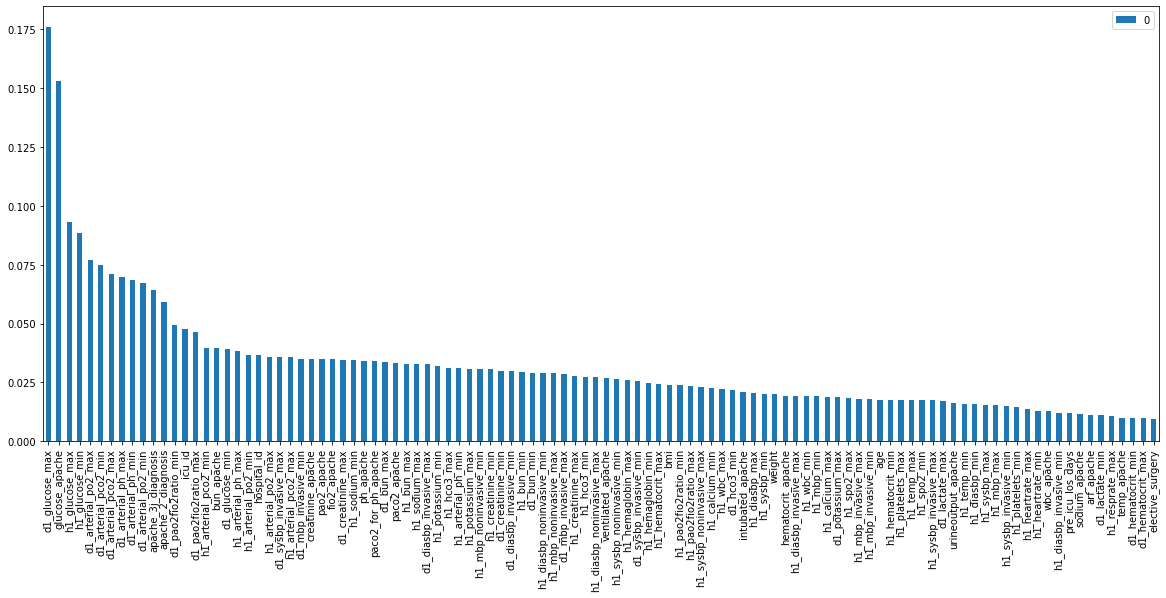

In [54]:
pd.DataFrame(mutual_info.sort_values(ascending=False)[:106]).plot.bar(figsize=(20,8))

In [55]:
MI= pd.DataFrame(mutual_info, columns=['value'], index=mutual_info.index)
k_number=MI['value'].count()- MI[MI['value']<0.011].count()

In [56]:
k_number

value    101
dtype: int64

In [57]:
select_cols = SelectKBest(mutual_info_classif, k= int(k_number))
select_cols.fit(X_train, y_train)

SelectKBest(k=101,
            score_func=<function mutual_info_classif at 0x00000234DE9874C0>)

In [58]:
new_columns = df.drop('diabetes_mellitus', axis=1).columns[select_cols.get_support()]

Reduced columns to 101 after feature selection

In [59]:
print(new_columns)

Index(['hospital_id', 'bmi', 'icu_id', 'weight', 'apache_2_diagnosis',
       'apache_3j_diagnosis', 'bun_apache', 'creatinine_apache', 'fio2_apache',
       'gcs_verbal_apache',
       ...
       'd1_pao2fio2ratio_max', 'd1_pao2fio2ratio_min', 'h1_arterial_pco2_max',
       'h1_arterial_pco2_min', 'h1_arterial_ph_max', 'h1_arterial_ph_min',
       'h1_arterial_po2_max', 'h1_arterial_po2_min', 'h1_pao2fio2ratio_max',
       'h1_pao2fio2ratio_min'],
      dtype='object', length=101)


In [60]:
X_train=pd.DataFrame(X_train)
X_train.columns = df.drop('diabetes_mellitus', axis=1).columns
X_train = X_train[new_columns]
X_test=pd.DataFrame(X_test)
X_test.columns = df.drop('diabetes_mellitus', axis=1).columns
X_test = X_test[new_columns]

# Artifitial neural network

In [61]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [62]:
history = model.fit(x=X_train ,y=y_train,validation_split=0.2,batch_size=32, epochs=25, 
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, patience=1)])

Epoch 1/25
986/986 [==============================] - 5s 4ms/step - loss: 0.4566 - accuracy: 0.7913 - val_loss: 0.4437 - val_accuracy: 0.8002
Epoch 2/25
986/986 [==============================] - 4s 4ms/step - loss: 0.4166 - accuracy: 0.8140 - val_loss: 0.4354 - val_accuracy: 0.8073
Epoch 3/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3989 - accuracy: 0.8222 - val_loss: 0.4368 - val_accuracy: 0.8048
Epoch 4/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3603 - accuracy: 0.8398 - val_loss: 0.4341 - val_accuracy: 0.8074
Epoch 5/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3462 - accuracy: 0.8449 - val_loss: 0.4403 - val_accuracy: 0.8049
Epoch 6/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3323 - accuracy: 0.8519 - val_loss: 0.4458 - val_accuracy: 0.8050
Epoch 7/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3301 - accuracy: 0.8533 - val_loss: 0.4461 - val_accuracy: 0.8049
Epoch 

In [63]:
model.evaluate(X_test,y_test)

528/528 [==============================] - 1s 3ms/step - loss: 0.4174 - accuracy: 0.8143


[0.4173598885536194, 0.8142797946929932]

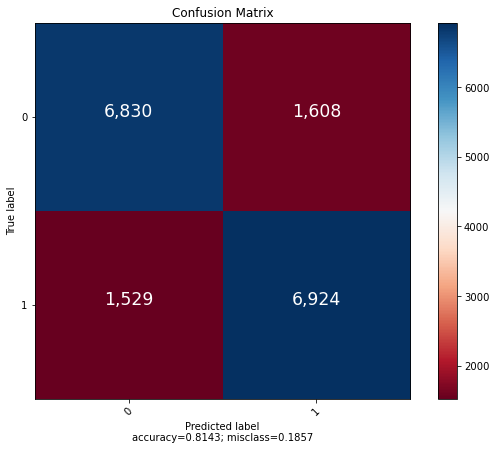

In [64]:
pred=model.predict(X_test)
pred=np.argmax(pred,axis=1)
cm= confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")
					  



In [65]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      8438
           1       0.81      0.82      0.82      8453

    accuracy                           0.81     16891
   macro avg       0.81      0.81      0.81     16891
weighted avg       0.81      0.81      0.81     16891



C:\Users\aditi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


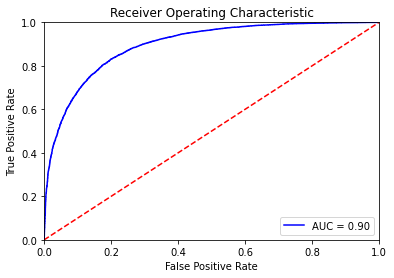

In [66]:
draw_roc(X_test, y_test, model)

# XGBoost

In [67]:
xgb1 = XGBClassifier( #Accuracy - 0.8537, AUC - 0.8906
 learning_rate =0.1,
 n_estimators=1200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder=False)
xgb1.fit(X_train, y_train)

pred = xgb1.predict(X_test)
print(accuracy_score(y_test, pred))

[09:36:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8352377005505891


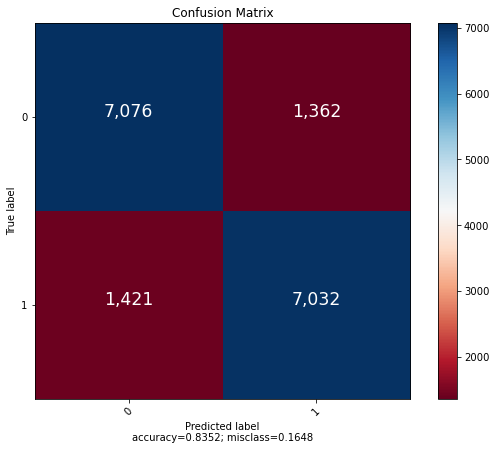

In [68]:
XGB_cm2=confusion_matrix(y_test, pred)
plot_confusion_matrix(XGB_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [69]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      8438
           1       0.84      0.83      0.83      8453

    accuracy                           0.84     16891
   macro avg       0.84      0.84      0.84     16891
weighted avg       0.84      0.84      0.84     16891



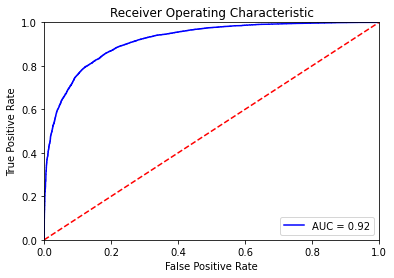

In [70]:
draw_roc(X_test, y_test, xgb1)

# CatBoost

In [71]:
model_cat = CatBoostClassifier(verbose=False,iterations=50)
model_cat.fit(X_train, y_train)

predictions = model_cat.predict(X_test)
print(accuracy_score(y_test, predictions))

print(classification_report(y_test, predictions))

0.8325735598839619
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      8438
           1       0.84      0.83      0.83      8453

    accuracy                           0.83     16891
   macro avg       0.83      0.83      0.83     16891
weighted avg       0.83      0.83      0.83     16891



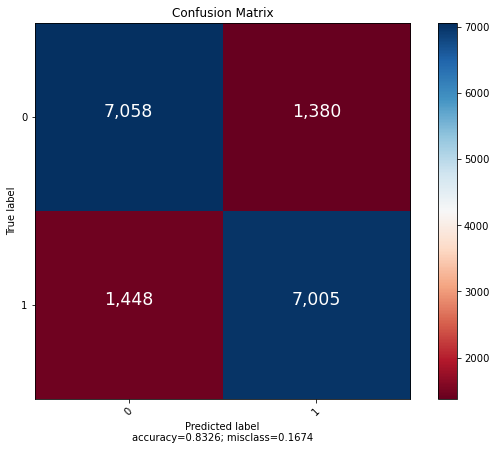

In [72]:
cm=confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

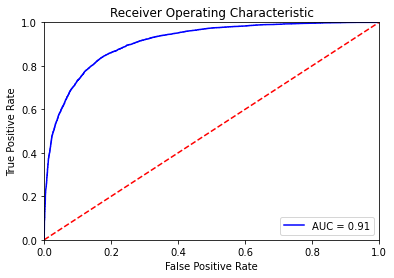

In [73]:
draw_roc(X_test, y_test, model_cat)

# Random forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


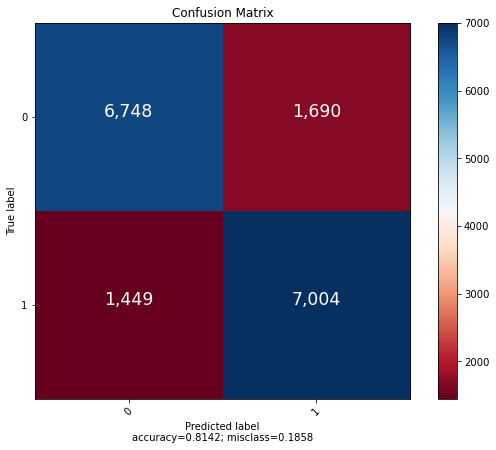

In [74]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=40, verbose = 1, n_jobs = -1)
random_forest.fit(X_train, y_train)
y_pred_rand=random_forest.predict(X_test)

rand_cm2=confusion_matrix(y_test, y_pred_rand)
plot_confusion_matrix(rand_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [75]:
print(classification_report(y_test, y_pred_rand))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8438
           1       0.81      0.83      0.82      8453

    accuracy                           0.81     16891
   macro avg       0.81      0.81      0.81     16891
weighted avg       0.81      0.81      0.81     16891



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


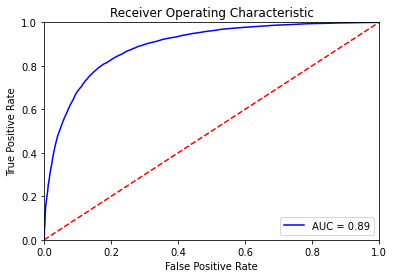

In [76]:
draw_roc(X_test, y_test, random_forest)

# Decision tree

In [77]:
Decision_model=DecisionTreeClassifier()
Decision_model.fit(X_train, y_train)

y_pred_Decission=Decision_model.predict(X_test)

print("Accuracy:",accuracy_score(y_test, y_pred_Decission))

Accuracy: 0.7196139956189687


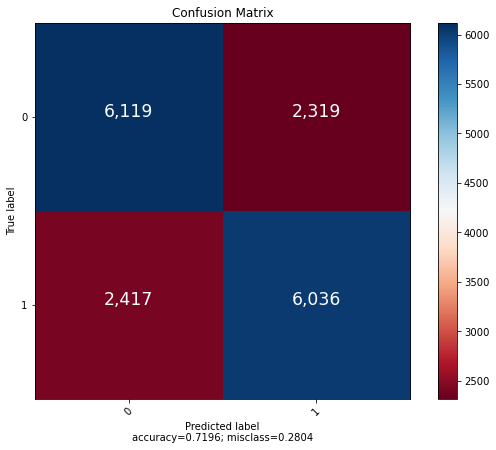

In [78]:
DT=confusion_matrix(y_test, y_pred_Decission)
plot_confusion_matrix(DT, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [79]:
print(classification_report(y_test, y_pred_Decission))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      8438
           1       0.72      0.71      0.72      8453

    accuracy                           0.72     16891
   macro avg       0.72      0.72      0.72     16891
weighted avg       0.72      0.72      0.72     16891



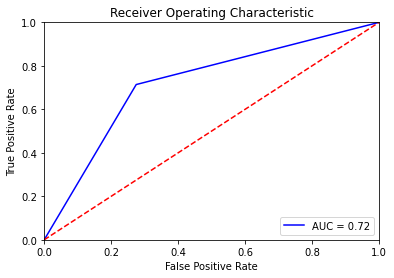

In [80]:
draw_roc(X_test, y_test, Decision_model)

# Principal component analysis(PCA)

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(39411, 173)

In [82]:
pca = PCA(n_components=124)
pca.fit(X_train)

PCA(n_components=124)

In [83]:
x_pca_train = pca.transform(X_train)
x_pca_test = pca.transform(X_test)

In [84]:
df_comp = pd.DataFrame(x_pca_train, columns=None)
df_comp_test = pd.DataFrame(x_pca_test, columns=None)

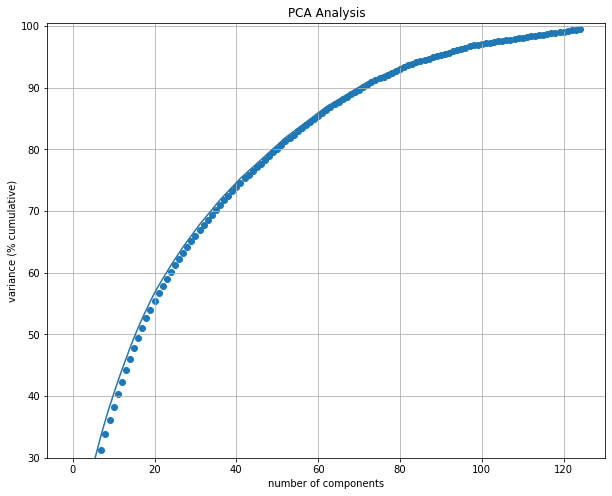

In [85]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
number = [n for n in range(1,125)]#int(k_number)+1)]
plt.figure(figsize=(10,8))
plt.ylabel('variance (% cumulative)')
plt.xlabel('number of components')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.grid(True)
plt.scatter(number,var)
plt.plot(var)

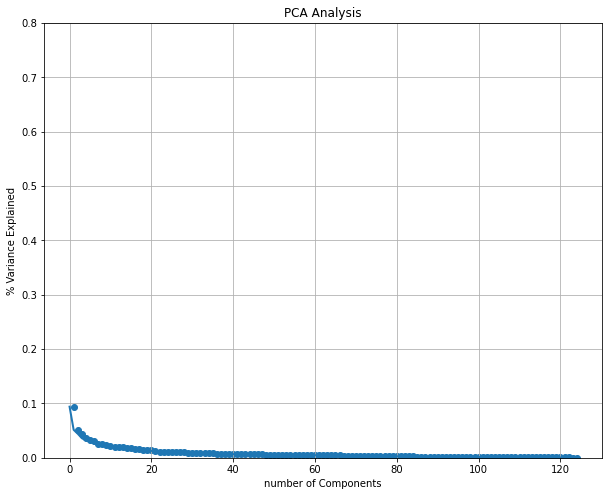

In [86]:
plt.figure(figsize=(10,8))
plt.ylabel('% Variance Explained')
plt.xlabel('number of Components')
plt.title('PCA Analysis')
plt.ylim(0,0.8)
plt.style.context('seaborn-whitegrid')
plt.grid(True)
plt.scatter(number, variance)
plt.plot(variance,lw=2)

# Artifitial neural network

In [87]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [88]:
history = model.fit(x=df_comp ,y=y_train,validation_split=0.2,batch_size=32, epochs=25, 
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('./model.h5', save_best_only=True),
                               tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, patience=1)])

Epoch 1/25
986/986 [==============================] - 5s 4ms/step - loss: 0.4595 - accuracy: 0.7878 - val_loss: 0.4339 - val_accuracy: 0.8021
Epoch 2/25
986/986 [==============================] - 4s 4ms/step - loss: 0.4025 - accuracy: 0.8194 - val_loss: 0.4301 - val_accuracy: 0.8013
Epoch 3/25
986/986 [==============================] - 5s 5ms/step - loss: 0.3755 - accuracy: 0.8332 - val_loss: 0.4367 - val_accuracy: 0.8067
Epoch 4/25
986/986 [==============================] - 4s 4ms/step - loss: 0.3132 - accuracy: 0.8597 - val_loss: 0.4462 - val_accuracy: 0.8102
Epoch 5/25
986/986 [==============================] - 7s 7ms/step - loss: 0.2888 - accuracy: 0.8715 - val_loss: 0.4484 - val_accuracy: 0.8104
Epoch 6/25
986/986 [==============================] - 7s 7ms/step - loss: 0.2859 - accuracy: 0.8732 - val_loss: 0.4487 - val_accuracy: 0.8105
Epoch 7/25
986/986 [==============================] - 6s 6ms/step - loss: 0.2856 - accuracy: 0.8735 - val_loss: 0.4488 - val_accuracy: 0.8105
Epoch 

In [89]:
model.evaluate(df_comp_test,y_test)
pred=model.predict(df_comp_test)

528/528 [==============================] - 2s 3ms/step - loss: 0.4298 - accuracy: 0.8142


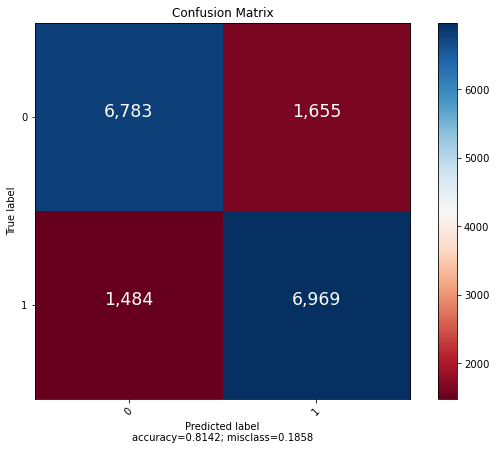

In [90]:
pred=np.argmax(pred,axis=1)
cm= confusion_matrix(y_test, pred)

plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [91]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8438
           1       0.81      0.82      0.82      8453

    accuracy                           0.81     16891
   macro avg       0.81      0.81      0.81     16891
weighted avg       0.81      0.81      0.81     16891



C:\Users\aditi\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


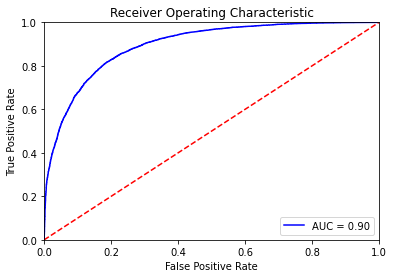

In [92]:
draw_roc(df_comp_test, y_test, model)

# XGBoost

In [93]:
xgb1 = XGBClassifier( #Accuracy - 0.8537, AUC - 0.8906
 learning_rate =0.1,
 n_estimators=900,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=30,
 use_label_encoder=False)
xgb1.fit(df_comp, y_train)

[09:41:49] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=30, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=30, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [94]:
pred = xgb1.predict(df_comp_test)
print(accuracy_score(y_test, pred))

0.8080634657509916


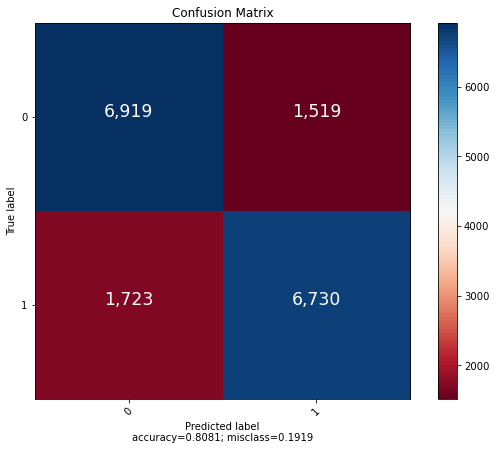

In [95]:
XGB_cm2=confusion_matrix(y_test, pred)
plot_confusion_matrix(XGB_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")

In [96]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      8438
           1       0.82      0.80      0.81      8453

    accuracy                           0.81     16891
   macro avg       0.81      0.81      0.81     16891
weighted avg       0.81      0.81      0.81     16891



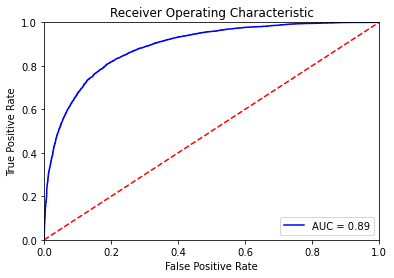

In [97]:
draw_roc(df_comp_test, y_test, xgb1)

# Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.7779882777810668


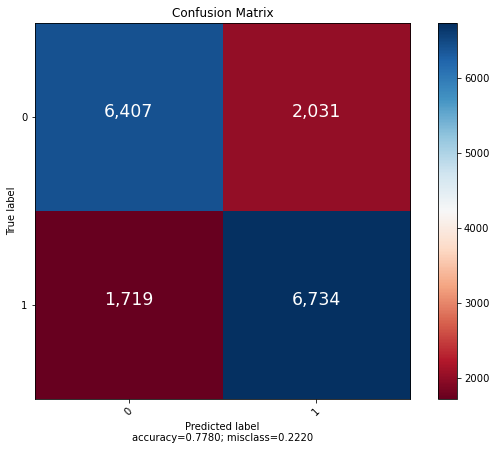

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      8438
           1       0.77      0.80      0.78      8453

    accuracy                           0.78     16891
   macro avg       0.78      0.78      0.78     16891
weighted avg       0.78      0.78      0.78     16891



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


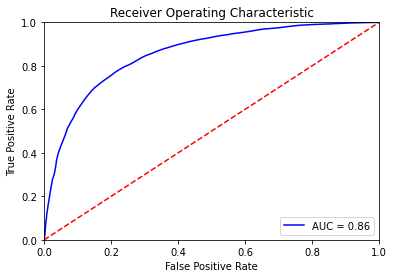

In [98]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=40, verbose = 1, n_jobs = -1)
random_forest.fit(df_comp, y_train)
y_pred_rand=random_forest.predict(df_comp_test)

print("Accuracy:",accuracy_score(y_test, y_pred_rand))

rand_cm2=confusion_matrix(y_test, y_pred_rand)
plot_confusion_matrix(rand_cm2, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")
					  
print(classification_report(y_test, y_pred_rand))

draw_roc(df_comp_test, y_test, random_forest)

# Catboost

Accuracy 0.7945651530400805
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      8438
           1       0.80      0.78      0.79      8453

    accuracy                           0.79     16891
   macro avg       0.79      0.79      0.79     16891
weighted avg       0.79      0.79      0.79     16891



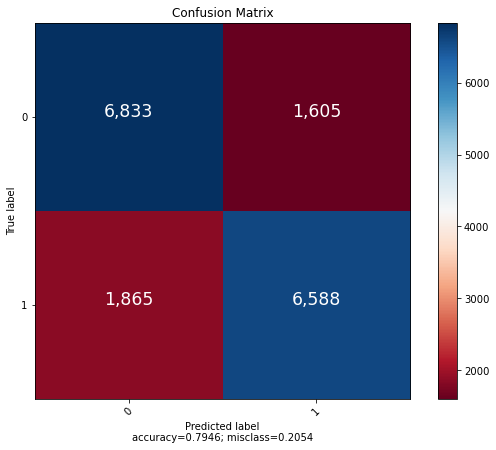

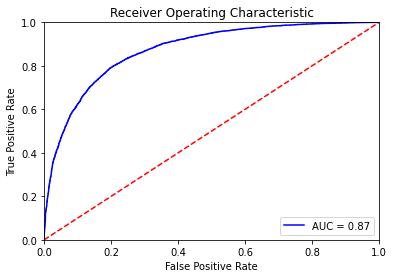

In [99]:
model_cat = CatBoostClassifier(verbose=False,iterations=50)
model_cat.fit(df_comp, y_train)
predictions = model_cat.predict(df_comp_test)
print('Accuracy', accuracy_score(y_test, predictions))

print(classification_report(y_test, predictions))

cm=confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")
					  
draw_roc(df_comp_test, y_test, model_cat)

# Decision Tree

Accuracy: 0.666686401041975
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      8438
           1       0.67      0.65      0.66      8453

    accuracy                           0.67     16891
   macro avg       0.67      0.67      0.67     16891
weighted avg       0.67      0.67      0.67     16891



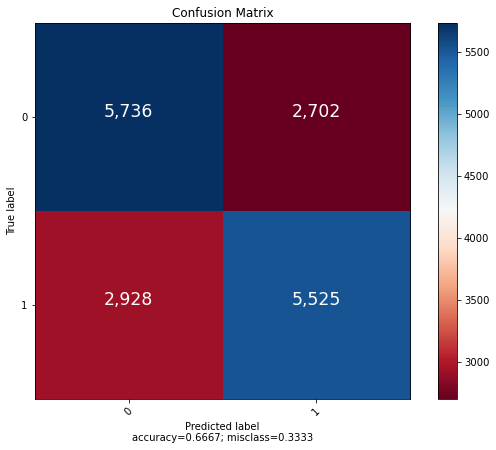

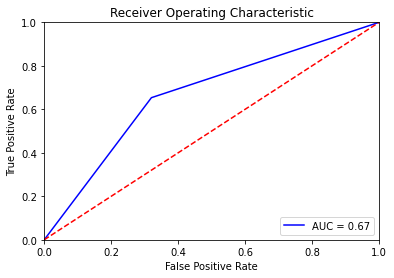

In [100]:
Decision_model=DecisionTreeClassifier()
Decision_model.fit(df_comp, y_train)

y_pred_Decission=Decision_model.predict(df_comp_test)

print("Accuracy:",accuracy_score(y_test, y_pred_Decission))
print(classification_report(y_test, y_pred_Decission))
DT=confusion_matrix(y_test, y_pred_Decission)
plot_confusion_matrix(DT, 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix")
					  
draw_roc(df_comp_test, y_test, Decision_model)

# Conclusion

This solution evaluated the best classification model as XGBoost among other selected models for the prediction of diabetes using ICU parameters for COVID-19 patients. XGBoost is considered as best suitable model based on its performance using performance metrices. Also, this study observed the comparison of the performance of the models with and without dimensionality reduction. From the observation, it is found that implementing feature selection in particular mutual information does not impact on the performance of the models whereas for feature extraction by implementing PCA, the performance of the model decreased noticeably. This study also selected the feature selection as the best suitable dimensionality reduction among feature selection and feature extraction because the dimensionality of the data reduced drastically in feature selection compared to feature extraction and also the performance of the models is higher in feature selection than in feature extraction. Beside this study gives brief information about some of the machine learning techniques such as handling imbalanced data, handling missing values so on and also this study showed how mutual information feature selection technique is helpful for medical professionals to understand the features which are influencing diabetes in this problem.

# References

https://www.kaggle.com/c/widsdatathon2021